<a href="https://colab.research.google.com/github/auw133/ARQuantWorkshop/blob/main/Quant_to_Qual_workshop_A_B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A website Click Through Rate example

Let us say we are redesigning a purcahse flow of a website, trying to compare effectiveness of revenue generation from the new vs. old design with simplification of a button click.

We will use [a free a/b test dataset](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv) from [Kaggle](https://www.kaggle.com/), a website with a lot of great resource to get you started. For now, I have it on [my Github](https://github.com/auw133/ARQuantWorkshop) to save you time in case you don't have account on Kaggle.  

In [60]:
import pandas as pd #pandas is one of the most used python library that you should be familiar with
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

url= "https://raw.githubusercontent.com/auw133/ARQuantWorkshop/main/ab_data.csv"
df=pd.read_csv(url)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [61]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


It was expected that the control group is being directed to the old page while the treatment group is directed to the new one. But seems a small fraction is not set up correctly. Lets get rid out of those that makes us confused.

In [62]:
df=df[~((df.group=='control')&(df.landing_page=='new_page'))]
df=df[~((df.group=='treatment')&(df.landing_page=='old_page'))]
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [66]:
#Check if the user ids are unique
df.drop_duplicates(subset ='user_id',keep ='first',inplace = True)
df.user_id.nunique(), df.shape[0]

(290584, 290584)

In [69]:
# let us only get those columns we need
df=df[['user_id','group','converted']]
df.head()

,user_id,group,converted
0,851104,control,0
1,804228,control,0
2,661590,treatment,0
3,853541,treatment,0
4,864975,control,1


## Forming hypothesis

Forming a realistic hypothesis upfront is the foundation to ensure correct interpretation and sometimes an effective way to hold teams accountable to take action on the results. 

Given we don't know if the new design will perform better or worse as our current design, a two-tailed test is a safe start:



> $H_0: p=p_0 \\
H_a: p \neq p_0$

where $p$ and $p_0$ stand for CTR of the new and old design, respectively. 

A common confidence level is set at 95%, meaning we are 95% confident CTR of new design is statistically different from the old design. Assuming that the null hypothesis is true, the probability of observing a result is lower than 5%, α=0.05. In this case, the null hypothesis should be rejected. 

## Design experiment

The design that users are exposed to is the **independent variable** in these experiment, which has two vaules: 
- Old design: the control user group 
- New design: the treatment (or variant, or experimental) user group 

Let us say that other than the design, we randomly assign users to reduce the effect from other variables that could impact on our results (e.g. seasonality. This way the only systematic difference between the groups is the product design. Therefore we can attribute any differences in results to the designs.

CTR is our **dependent variable**. We code this is by each user session with a binary variable:
0 - The user did not buy the product during this user session
1 - The user bought the product during this user session
This way, we can easily calculate the mean for each group to get the CTR of each design.

Now we have two groups with each has ~145K users.

In [70]:
df['group'].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

## Sample size

Note that we rarely be able to test the whole user base (population). Rather, a sample is used to *estimate*. Sample size (# of users in each group) has an effect on the precision of our estimate: 
- The larger the sample size, the more precise our estimates (the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present. 
- On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.


Power analysis is used to answer "*how many people should we have in each group?*", which depends on a few factors:
- **Significance level (α)** — The critical value we set earlier to 0.05;
- **Statistical power**: This represents the probability of finding the difference when a difference is actually present. This is usually set at 0.8 by convention. Lear more about [statistical power](https://colab.research.google.com/drive/1bPREMlvp90-UqB7hYQ5nbIi5liaB8ABI#scrollTo=8nt_spzKcbvx&line=41&uniqifier=1). 
- **Effect size**: How big of a difference we expect there to be between the CTRs to be observable. This is often overlooked. We need to know the existing design CTR and desired difference, let us say 1%. 

In [71]:
df.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

We also noticed that the control group CTR is 12%, which we will use it as reference of our existing CTR. 

In [72]:
effect_size = sms.proportion_effectsize(0.12, 0.13)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
print(required_n)

17164


## Sampling

This means that we need at least **17164** users in each group. We will simply randomly sample from the dataset. 

*Question: what if the team is ok with observing 5% difference in effect size. Do we need bigger or smaller sample?*
  

In [76]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=1) # to get the random sample rsult reproducible
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=1)

ab_test = pd.concat([control_sample, treatment_sample], axis=0) # combine the two groups back to one
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,group,converted
0,813238,control,0
1,734870,control,0
2,761195,control,0
3,867268,control,0
4,733746,control,0
...,...,...,...
34323,748642,treatment,0
34324,924541,treatment,0
34325,751005,treatment,0
34326,892667,treatment,1


## Test Hypothesis

Let us get the descriptive stats of the two groups. It seems that they perform pertty close, 😏

In [77]:
conversion_rates = ab_test.groupby('group')['converted']
conversion_rates = conversion_rates.agg([np.mean, np.std, stats.sem]) #mean, standard deviation, standard error
conversion_rates.columns = ['CTR', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,CTR,std_deviation,std_error
group,,,
control,0.120,0.325,0.002
treatment,0.118,0.323,0.002


Now let us formally test our hypothesis. Since we have a large sample, we can use the normal approximation for calculating our p-value (i.e. z-test). It turned out that the new design is actually not performing better, given p-value is larger than 0.5, and the CIs contains the average CTR for the two groups. 

In [79]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


p-value: 0.629
ci 95% for control group: [0.115, 0.125]
ci 95% for treatment group: [0.113, 0.123]


We can also visualize the results with a simple bar chart with errorbars


Text(0, 0.5, 'CTR')

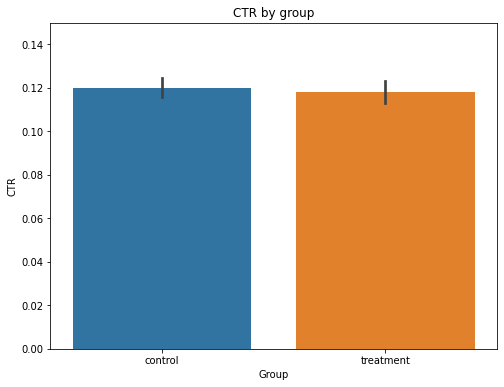

In [82]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'],errorbar=('ci',95))

plt.ylim(0, 0.15)
plt.title('CTR by group')
plt.xlabel('Group')
plt.ylabel('CTR')